In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Base (1).csv')

c:\estudos\POS\Fraudes-Financeiras\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9943    0.9462    0.9697    197794
           1     0.0964    0.5150    0.1624      2206

    accuracy                         0.9414    200000
   macro avg     0.5454    0.7306    0.5660    200000
weighted avg     0.9844    0.9414    0.9607    200000



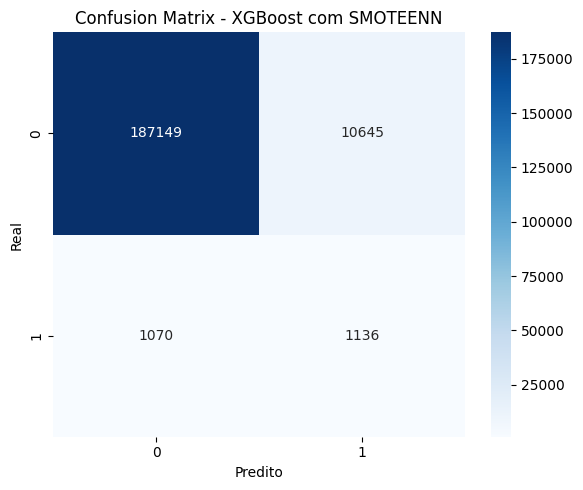

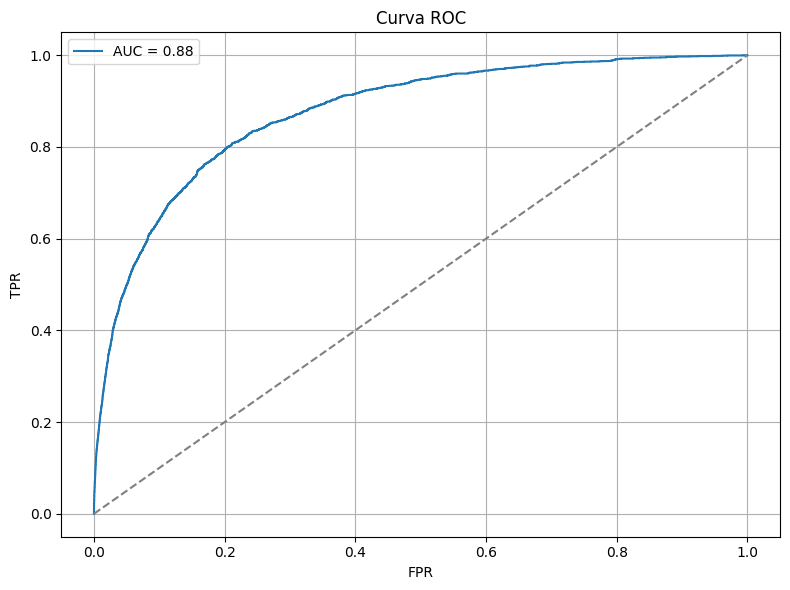

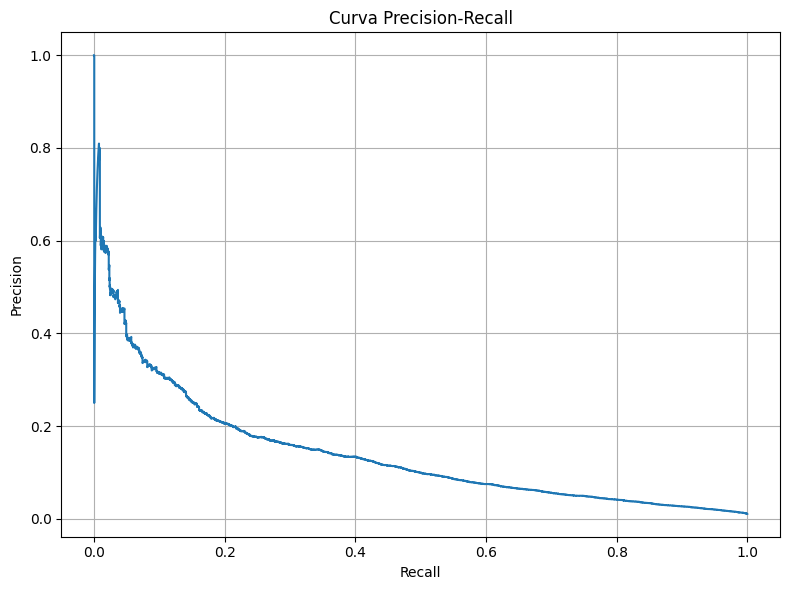

In [5]:
# ⚙️ Funções utilitárias
def carregar_dados(caminho_csv):
    return pd.read_csv(caminho_csv)

def codificar_dados(df):
    df = df.copy()
    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)
    return df

def tratar_nulos(X):
    imputer = SimpleImputer(strategy='median')
    return pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

def preparar_dados(df):
    df = df.dropna(subset=['fraud_bool'])
    X = df.drop(columns=["fraud_bool"])
    y = df["fraud_bool"]
    X = codificar_dados(X)
    X = tratar_nulos(X)
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def balancear_amostras(X_train, y_train):
    X_sampled, _, y_sampled, _ = train_test_split(
        X_train, y_train, stratify=y_train, test_size=0.8, random_state=42
    )
    smote_enn = SMOTEENN(random_state=42)
    return smote_enn.fit_resample(X_sampled, y_sampled)

def treinar_modelo(X, y):
    model = XGBClassifier(
        scale_pos_weight=10,
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X, y)
    return model

def avaliar_modelo(model, X_test, y_test, threshold=0.4):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - XGBoost com SMOTEENN")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall")
    plt.grid()
    plt.tight_layout()
    plt.show()

# 🚀 Execução no Colab
caminho_csv = "Base (1).csv"  # Substitua com o nome correto do seu upload no Colab
df = carregar_dados(caminho_csv)
X_train, X_test, y_train, y_test = preparar_dados(df)
X_bal, y_bal = balancear_amostras(X_train, y_train)
modelo = treinar_modelo(X_bal, y_bal)
avaliar_modelo(modelo, X_test, y_test)
